<a href="https://colab.research.google.com/github/keamanansiber/Maryam/blob/master/notebooks/Prototype_4_TopicModeling_0_1_0_CsvFile_Options_StopwordsRemoval_27062022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sentence-transformers
!pip install umap-learn
!pip install bertopic
!pip install dask
!pip install dask[dataframe] 
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# core/util/iris/topicmodeling.py

import pandas as pd
import numpy as np
import json
import csv
from dask import dataframe as dd

from sklearn.cluster import KMeans
import scipy
import matplotlib.pyplot as plt
import umap

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS



class topicmodeling:



	def __init__(self, inputfile, filetype="json", showhistogram=False, verbose=False):


		if verbose:
			print("\n\n DATASET = reading file : " + inputfile)

		if filetype == "csv" :
			#tmp = pd.read_csv(inputfile, header=None, low_memory=False)
			tmp = dd.read_csv(inputfile,sep=';', header=None)
			tmp2 = tmp.to_dask_array(lengths=True)
			tmp3 = tmp2.compute()
			tmp4 = pd.DataFrame(tmp3)

			if verbose:
				print("\n\n csv file (before preprocessing) = ")
				print(tmp4)
		
			self.corpus = tmp4[0].str.lower().apply(remove_stopwords).to_numpy()
			
		elif filetype == "json" :
			with open(inputfile) as json_file:
			  jsonfile = json.load(json_file)

			tmp = pd.DataFrame(jsonfile['results'])

			if verbose:
				print("\n\n json file (before preprocessing) = ")
				print(tmp)
				
			tmp['td'] = tmp['t'] + ' ' + tmp['d']
			self.corpus = tmp['td'].str.lower().apply(remove_stopwords).to_numpy()
			
		else :
			print("ERROR, only accept csv or json file!")

		
		if verbose:
			print("\n\n number of corpus = ")
			print(len(self.corpus))
			print("\n\n self.corpus[0] = ")
			print(self.corpus[0])
			print("\n\n all self.corpus = ")
			print(self.corpus)


		if showhistogram:
			print("\n\n histogram of the number of words in each corpus")
			pd.Series([len(e.split()) for e in self.corpus]).hist()



	def run_sklearn_cluster_means(self, selected_pretrained_model, verbose=False):		
	

		pretrained_model = selected_pretrained_model
		if verbose:
			print("\n\n Model selection")
			# https://www.sbert.net/docs/pretrained_models.html
			print(pretrained_model)

		model = SentenceTransformer(pretrained_model)
		if verbose:
			print(model)


		corpus_embeddings = model.encode(self.corpus)
		if verbose:
			print("\n\n CORPUS EMBEDDING")
			print(corpus_embeddings.shape)
			print(corpus_embeddings)

		
		K=5
		kmeans = KMeans(n_clusters=5, random_state=0).fit(corpus_embeddings)
		if verbose:
			print("\n\n Show Cluster using SkLearn KMeans")
			print(kmeans)


		corpus_labeled = pd.DataFrame({'ClusterLabel':kmeans.labels_, 'Sentence':self.corpus})
		print("\n\n corpus_labeled = ")
		print(corpus_labeled)


		cls_dist=pd.Series(kmeans.labels_).value_counts()
		if verbose:
			print("\n\n frequency of cluster label = ")
			print(cls_dist)


		distances = scipy.spatial.distance.cdist(kmeans.cluster_centers_ , corpus_embeddings)
		if verbose:
			print("\n\n calculate distance of cluster's center point = ")
			print(distances)


		print("\n\n Cluster's center example = ")

		centers={}
		print("Cluster", "Size", "Center-idx", "Center-Example", sep="\t\t")
		for i,d in enumerate(distances):
			ind = np.argsort(d, axis=0)[0]
			centers[i]=ind
			print(i,cls_dist[i], ind, self.corpus[ind] ,sep="\t\t")


		print("\n\n Visualization of the cluster points")

		X = umap.UMAP(n_components=2, min_dist=0.0).fit_transform(corpus_embeddings)
		labels= kmeans.labels_

		fig, ax = plt.subplots(figsize=(12, 8))
		plt.scatter(X[:,0], X[:,1], c=labels, s=1, cmap='Paired')
		for c in centers:
			plt.text(X[centers[c],0], X[centers[c], 1], "CLS-"+ str(c), fontsize=24) 
		plt.colorbar()



	def run_topic_modeling_bertopic(self, selected_pretrained_model, verbose=False):		
	

		pretrained_model = selected_pretrained_model
		if verbose:
			print("\n\n Model selection")
			# https://www.sbert.net/docs/pretrained_models.html
			print(pretrained_model)

		model = SentenceTransformer(pretrained_model)
		if verbose:
			print(model)


		corpus_embeddings = model.encode(self.corpus)
		if verbose:
			print("\n\n CORPUS EMBEDDING")
			print(corpus_embeddings.shape)
			print(corpus_embeddings)


		print("\n\n Topic Modeling with BERTopic")

		sentence_model = SentenceTransformer(pretrained_model)
		if verbose:
			print(sentence_model)

		topic_model = BERTopic(embedding_model=sentence_model)
		if verbose:
			print(topic_model)

		topics, _ = topic_model.fit_transform(self.corpus)
		print(topic_model.get_topic_info()[:6])


		corpus_labeled = pd.DataFrame({'ClusterLabel':topics, 'Sentence':self.corpus})
		if verbose:
			print("\n\n corpus_labeled = ")
			print(corpus_labeled)


		print("\n\n topics for each cluster = ")

		i=0
		while i < len(topic_model.get_topic_info()):
			print("Cluster #" + str(i) + " = ")
			print(topic_model.get_topic(i))
			i+=1
		
		

# JSON

In [3]:
# Use dataset from Mr. Khausik's work https://github.com/k4u5h1k/Doclustering/blob/main/mixed.json
jsonfile = "mixed.json"

tm = topicmodeling(jsonfile)



 histogram of the number of words in each corpus


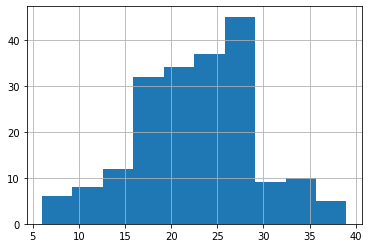

In [4]:
tm = topicmodeling(jsonfile, showhistogram=True)

In [5]:
tm = topicmodeling(jsonfile, verbose=True)



 DATASET = reading file : mixed.json


 json file (before preprocessing) = 
                                                     t  \
0                             Movie Coverage - YouTube   
1       Marvel Studios Celebrates The Movies - YouTube   
2                       FRESH Movie Trailers - YouTube   
3                           Movie: The Movie - YouTube   
4    Tippu Hindi Dubbed Full Movie | Satya Karthik,...   
..                                                 ...   
193  Amazon Music Unlimited | 70 million songs ad-f...   
194                  Music Ally Is A Knowledge Company   
195                              Music - Rolling Stone   
196  MusicRadar: Music Gear, Equipment, News, Tutor...   
197                Get started | Learning Music (Beta)   

                                                     a  \
0    https://www.youtube.com/channel/UCwYzZs_hwA6Nd...   
1      https://www.youtube.com/watch%3Fv%3DQdpxoFcdORI   
2         https://www.youtube.com/c/FreshMovieTrail



 DATASET = reading file : mixed.json


 json file (before preprocessing) = 
                                                     t  \
0                             Movie Coverage - YouTube   
1       Marvel Studios Celebrates The Movies - YouTube   
2                       FRESH Movie Trailers - YouTube   
3                           Movie: The Movie - YouTube   
4    Tippu Hindi Dubbed Full Movie | Satya Karthik,...   
..                                                 ...   
193  Amazon Music Unlimited | 70 million songs ad-f...   
194                  Music Ally Is A Knowledge Company   
195                              Music - Rolling Stone   
196  MusicRadar: Music Gear, Equipment, News, Tutor...   
197                Get started | Learning Music (Beta)   

                                                     a  \
0    https://www.youtube.com/channel/UCwYzZs_hwA6Nd...   
1      https://www.youtube.com/watch%3Fv%3DQdpxoFcdORI   
2         https://www.youtube.com/c/FreshMovieTrail

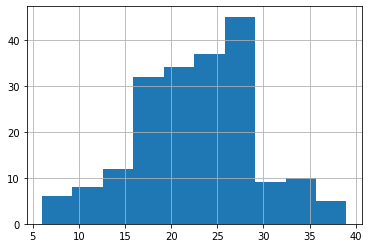

In [6]:
tm = topicmodeling(jsonfile, showhistogram=True, verbose=True)

# CSV

In [7]:
# Hatma Suryotrisongko's dataset, consists of title, abstract, and keywords combined, taken from paper journal and conference proceedings published in 2020-2022, from SCOPUS database (retrieved 26/06/2022).
# testdataset.csv
# scopus_cybersecurity_conferenceproceeding.csv
# scopus_cybersecurity_journalAndProceeding.csv
# scopus_cybersecurity_journalarticles.csv

tm = topicmodeling(inputfile="testdataset.csv", filetype="csv")

In [8]:
tm = topicmodeling(inputfile="scopus_cybersecurity_conferenceproceeding.csv", filetype="csv", verbose=True)



 DATASET = reading file : scopus_cybersecurity_conferenceproceeding.csv


 csv file (before preprocessing) = 
                                                      0
0     Development of cyber security and privacy by p...
1     Implementing cyber security policy for Big Dat...
2     It was hard to find the words : Using an Autoe...
3     Integrated Approach to Cybersecurity of a Smal...
4     Applying Blockchain to Vehicle Cybersecurity: ...
...                                                 ...
1408  Singapore’s cybersecurity act 2018: A new gene...
1409  Cybersecurity and Digital Forensics – Course D...
1410  Implementation of Active Learning in the Maste...
1411  Algorithms for Forming a Knowledge Base for De...
1412  Applications of Machine Learning in Cyber Secu...

[1413 rows x 1 columns]


 number of corpus = 
1413


 self.corpus[0] = 
development cyber security privacy precision decentralized actionable threat risk management mobile communication internet things (iot).in rec



 histogram of the number of words in each corpus


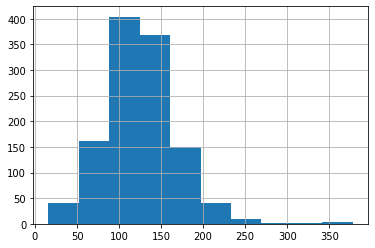

In [9]:
tm = topicmodeling(inputfile="scopus_cybersecurity_journalarticles.csv", filetype="csv", showhistogram=True)



 DATASET = reading file : scopus_cybersecurity_journalAndProceeding.csv


 csv file (before preprocessing) = 
                                                      0
0     Cybersecurity in the food and beverage industr...
1     The role of cybersecurity and policy awareness...
2     Cybersecurity strategy under uncertainties for...
3     The Cultural Construction of Cybersecurity: Di...
4     The role of national cybersecurity strategies ...
...                                                 ...
2590  Singapore’s cybersecurity act 2018: A new gene...
2591  Cybersecurity and Digital Forensics – Course D...
2592  Implementation of Active Learning in the Maste...
2593  Algorithms for Forming a Knowledge Base for De...
2594  Applications of Machine Learning in Cyber Secu...

[2595 rows x 1 columns]


 number of corpus = 
2595


 self.corpus[0] = 
cybersecurity food beverage industry: reference framework. given tendency food companies adopt digital technologies food supply chain importan

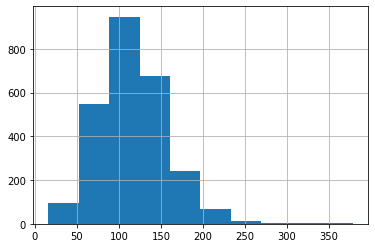

In [10]:
tm = topicmodeling(inputfile="scopus_cybersecurity_journalAndProceeding.csv", filetype="csv", showhistogram=True, verbose=True)

# Run the algorithms

**Users can choose one of the available model from https://www.sbert.net/docs/pretrained_models.html**

*For example=*

all-mpnet-base-v2 

multi-qa-mpnet-base-dot-v1 

all-distilroberta-v1 

all-MiniLM-L12-v2 

multi-qa-distilbert-cos-v1 

all-MiniLM-L6-v2 

multi-qa-MiniLM-L6-cos-v1 

paraphrase-multilingual-mpnet-base-v2 

paraphrase-albert-small-v2 

paraphrase-multilingual-MiniLM-L12-v2 

paraphrase-MiniLM-L3-v2 

distiluse-base-multilingual-cased-v1 

distiluse-base-multilingual-cased-v2 

...

## Clustering



 corpus_labeled = 
      ClusterLabel                                           Sentence
0                3  cybersecurity food beverage industry: referenc...
1                3  role cybersecurity policy awareness shifting e...
2                1  cybersecurity strategy uncertainties ioe envir...
3                3  cultural construction cybersecurity: digital t...
4                4  role national cybersecurity strategies improve...
...            ...                                                ...
2590             3  singapore’s cybersecurity act 2018: new genera...
2591             4  cybersecurity digital forensics – course devel...
2592             4  implementation active learning master’s progra...
2593             1  algorithms forming knowledge base decision sup...
2594             2  applications machine learning cyber security -...

[2595 rows x 2 columns]


 Cluster's center example = 
Cluster		Size		Center-idx		Center-Example
0		361		131		effective cyber security iot

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


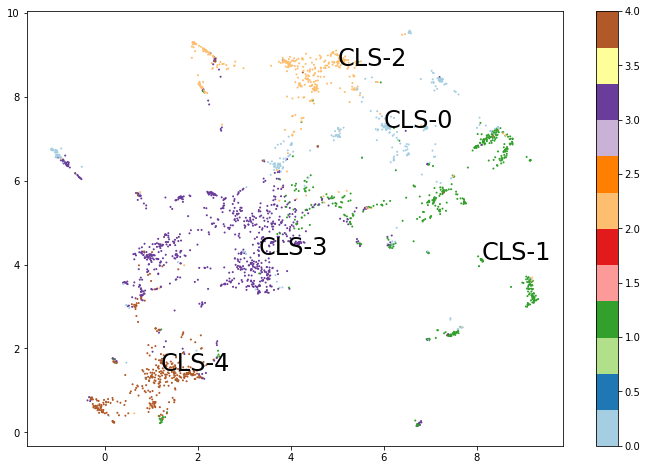

In [11]:
tm.run_sklearn_cluster_means("all-mpnet-base-v2")



 corpus_labeled = 
      ClusterLabel                                           Sentence
0                1  cybersecurity food beverage industry: referenc...
1                4  role cybersecurity policy awareness shifting e...
2                0  cybersecurity strategy uncertainties ioe envir...
3                1  cultural construction cybersecurity: digital t...
4                2  role national cybersecurity strategies improve...
...            ...                                                ...
2590             1  singapore’s cybersecurity act 2018: new genera...
2591             2  cybersecurity digital forensics – course devel...
2592             2  implementation active learning master’s progra...
2593             0  algorithms forming knowledge base decision sup...
2594             3  applications machine learning cyber security -...

[2595 rows x 2 columns]


 Cluster's center example = 
Cluster		Size		Center-idx		Center-Example
0		581		193		cyber security: review cyber

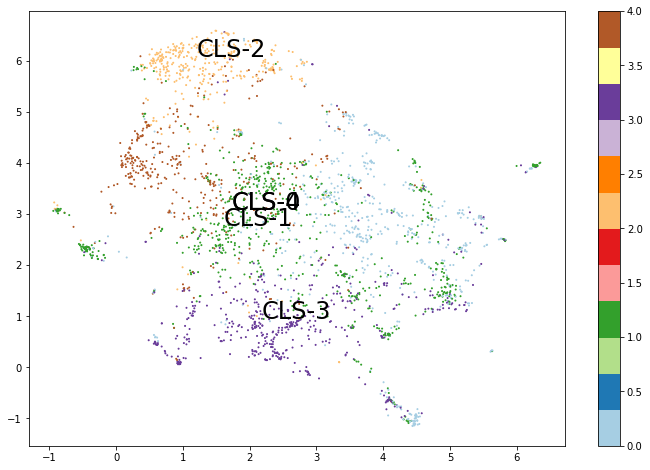

In [12]:
tm.run_sklearn_cluster_means("multi-qa-mpnet-base-dot-v1", verbose=False)



 Model selection
all-distilroberta-v1
SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)


 CORPUS EMBEDDING
(2595, 768)
[[-0.01005783 -0.03815427 -0.02501025 ... -0.0551856   0.02162146
   0.00687729]
 [ 0.007858    0.0009325  -0.02229459 ... -0.07033266  0.04359503
  -0.00277262]
 [ 0.01469262 -0.00256297 -0.00366135 ... -0.03671569 -0.00827174
   0.04485366]
 ...
 [ 0.03633476 -0.0190416  -0.00913019 ... -0.02978667  0.0151864
  -0.01199013]
 [ 0.0202656  -0.01316146 -0.00013489 ... -0.05673137  0.04120386
  -0.00400831]
 [-0.00688426 -0.06705717 -0.01514774 ... -0.07373495  0.07173698
   0.02400743]]


 Show Cluster using SkLearn KMeans
KMeans(n_clusters=5, random_state=0)


 corpus_labeled = 

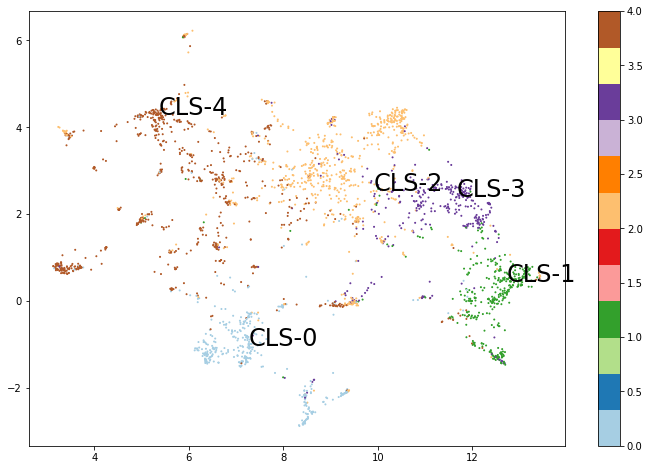

In [13]:
tm.run_sklearn_cluster_means("all-distilroberta-v1", verbose=True)


## Topic Modeling

In [14]:
tm.run_topic_modeling_bertopic("all-MiniLM-L12-v2")



 Topic Modeling with BERTopic
   Topic  Count                                         Name
0     -1    479  -1_security_cyber_cybersecurity_information
1      0    407  0_education_students_cybersecurity_training
2      1    212            1_learning_machine_detection_deep
3      2    143                    2_power_grid_energy_smart
4      3    142     3_behavior_awareness_human_cybersecurity
5      4    129         4_risk_assessment_maturity_framework


 topics for each cluster = 
Cluster #0 = 
[('education', 0.031869122378632736), ('students', 0.026375852201097796), ('cybersecurity', 0.024728407374607804), ('training', 0.021582144924434332), ('learning', 0.020966598014053418), ('skills', 0.018528067137516844), ('game', 0.013888664592452363), ('teaching', 0.013235016500847279), ('security', 0.012995539306293496), ('course', 0.012450694509022095)]
Cluster #1 = 
[('learning', 0.04183236004865432), ('machine', 0.03763480589835435), ('detection', 0.03294043502333246), ('deep', 0.0263241

In [15]:
tm.run_topic_modeling_bertopic("multi-qa-distilbert-cos-v1", verbose=False)



 Topic Modeling with BERTopic
   Topic  Count                                         Name
0     -1    914  -1_cybersecurity_security_cyber_information
1      0    203            0_learning_machine_detection_deep
2      1    158    1_education_students_cybersecurity_skills
3      2    114                    2_grid_power_smart_energy
4      3     98      3_automotive_vehicle_vehicles_connected
5      4     89          4_healthcare_health_medical_devices


 topics for each cluster = 
Cluster #0 = 
[('learning', 0.042042815210112924), ('machine', 0.03667460400668294), ('detection', 0.03481580026215526), ('deep', 0.024814082668081622), ('data', 0.023398470897546184), ('intrusion', 0.019786579967488633), ('network', 0.01929045701619331), ('artificial', 0.018773281635777034), ('ai', 0.018077711143550067), ('ml', 0.016379439662982748)]
Cluster #1 = 
[('education', 0.0424072981531868), ('students', 0.037886261571716366), ('cybersecurity', 0.028776498240758196), ('skills', 0.02649536525273234

In [16]:
tm.run_topic_modeling_bertopic("all-MiniLM-L6-v2", verbose=True)



 Model selection
all-MiniLM-L6-v2
SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)


 CORPUS EMBEDDING
(2595, 384)
[[ 0.00779645 -0.06346683 -0.05560001 ... -0.07745775  0.03807752
   0.00643961]
 [ 0.02981658 -0.0188575   0.01508859 ... -0.05283225  0.02082234
   0.01397314]
 [-0.01619928  0.00226542 -0.05495644 ... -0.07817202 -0.03260474
   0.02075503]
 ...
 [-0.03014697  0.02603674  0.00339436 ... -0.06644577 -0.015085
   0.06815896]
 [ 0.01344105  0.00966296 -0.05613481 ... -0.04336623  0.01981903
   0.02209058]
 [-0.05680034 -0.01470756 -0.00768282 ... -0.06331515 -0.01802399
   0.03241713]]


 Topic Modeling with BERTopic
SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lo